In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
# optimizer
ga = GA(
    dict(
        m = 50,
        x_rate = [0.5, 1.0],
        m_rate = [0.6, 1.0],
        weight_constraint = [-3.,3.],
        radioactive_rating = [0.5, 1.0],
        grow_factor = [0.5, 1.0],
        scale_hyperparameter = False))

In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = ga, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy', 'precision', 'recall', 'f1'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\tcumi\\github_repo\\neural-network\\', 'dataset')
GROUP = 5
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)
    itr = century + breakpoint
    model.optimizer.rr = model.optimizer.rr * 0.9
    model.optimizer.gf = model.optimizer.gf * 0.9
    model.optimizer.crossover_rate = model.optimizer.crossover_rate * 0.9
    model.optimizer.mutation_rate = model.optimizer.mutation_rate * 1.1
    '''
    model.rr = model.radioactive_rating[1] - (model.radioactive_rating[1] - model.radioactive_rating[0]) / EPOCHS * (EPOCHS - itr)
    model.gf = model.grow_factor[1] - (model.grow_factor[1] - model.grow_factor[0]) / EPOCHS * (EPOCHS - itr)
    model.crossover_rate = model.x_rate[1] - (model.x_rate[1] - model.x_rate[0]) / EPOCHS * (EPOCHS - itr)
    model.mutation_rate = model.m_rate[0] + (model.m_rate[1] - model.m_rate[0]) / EPOCHS * (EPOCHS - itr)
    '''
    

C:\Users\tcumi\github_repo\neural-network\python\activations.py:14: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-Xi))
C:\Users\tcumi\github_repo\neural-network\python\ga.py:189: RuntimeWarning: overflow encountered in add
  self.population.sort(key=lambda p: p.fitness + np.random.uniform(-shift, shift, 1), reverse = self.aim)


Checkpoint 100, Accuracy: 0.845679012345679, Loss: 0.6929843337447555
Checkpoint 200, Accuracy: 0.8395061728395061, Loss: 0.6858162350124783
Checkpoint 300, Accuracy: 0.8333333333333334, Loss: 0.688744721589265
Checkpoint 400, Accuracy: 0.8333333333333334, Loss: 0.6872637713396991
Checkpoint 500, Accuracy: 0.8333333333333334, Loss: 0.6834605888084129


In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for y in y_list:
        ax.plot(x, y)
    if x_label is not None and y_label is not None:
        title = '{} VS {}'.format(x_label, y_label)
        ax.set(xlabel=x_label, ylabel=y_label, title=title)
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

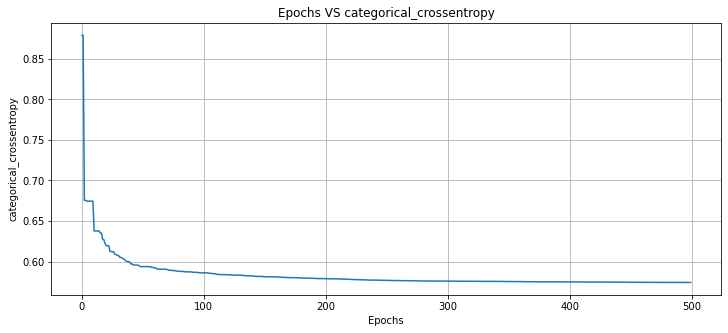

In [10]:
draw_plot(x = [i for i in range(len(history))], y_list = [history], x_label = 'Epochs', \
    y_label = model.loss_fn)

In [11]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [[0.9309462 ]
 [0.03730768]
 [0.03174611]]
[0. 1. 0.] <-> [[0.32629243]
 [0.37606582]
 [0.29764172]]
[0. 1. 0.] <-> [[0.47263613]
 [0.3153451 ]
 [0.21201873]]
[1. 0. 0.] <-> [[0.35826072]
 [0.36464527]
 [0.27709404]]
[0. 1. 0.] <-> [[0.12496883]
 [0.406525  ]
 [0.4685062 ]]
[1. 0. 0.] <-> [[0.922794  ]
 [0.04186212]
 [0.03534394]]
[1. 0. 0.] <-> [[0.65426344]
 [0.22732392]
 [0.11841265]]
[1. 0. 0.] <-> [[0.92120785]
 [0.04275412]
 [0.03603809]]
[1. 0. 0.] <-> [[0.90958416]
 [0.04967977]
 [0.04073606]]
[0. 1. 0.] <-> [[0.46108535]
 [0.37497923]
 [0.16393544]]
[1. 0. 0.] <-> [[0.92231816]
 [0.04212843]
 [0.03555339]]
[1. 0. 0.] <-> [[0.48247796]
 [0.3119157 ]
 [0.20560628]]
[1. 0. 0.] <-> [[0.932422  ]
 [0.03647386]
 [0.03110413]]
[0. 1. 0.] <-> [[0.06053086]
 [0.38639626]
 [0.55307287]]
[1. 0. 0.] <-> [[0.85439044]
 [0.08517076]
 [0.06043877]]
[1. 0. 0.] <-> [[0.3527531 ]
 [0.3667003 ]
 [0.28054667]]
[0. 0. 1.] <-> [[0.08610829]
 [0.39695993]
 [0.5169318 ]]
[1. 0. 0.] <->

C:\Users\tcumi\github_repo\neural-network\python\activations.py:14: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-Xi))


In [12]:
# Testing Performance

In [13]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.845679012345679, 'mean_square_error': 2.8939590221108116, 'categorical_crossentropy': 0.6929843337447555, 'precision': 0.7685185185185185, 'recall': 0.7685185185185185, 'f1': 0.7685185185185186, 'essential_metrics': {0: {'tp_hit': 74, 'fp_hit': 15, 'tn_hit': 17, 'fn_hit': 2}, 1: {'tp_hit': 2, 'fp_hit': 5, 'tn_hit': 86, 'fn_hit': 15}, 2: {'tp_hit': 7, 'fp_hit': 5, 'tn_hit': 88, 'fn_hit': 8}}, 'checkpoint': 100} 


{'accuracy': 0.8395061728395061, 'mean_square_error': 2.89672893367144, 'categorical_crossentropy': 0.6858162350124783, 'precision': 0.7592592592592593, 'recall': 0.7592592592592593, 'f1': 0.7592592592592593, 'essential_metrics': {0: {'tp_hit': 73, 'fp_hit': 15, 'tn_hit': 17, 'fn_hit': 3}, 1: {'tp_hit': 2, 'fp_hit': 6, 'tn_hit': 85, 'fn_hit': 15}, 2: {'tp_hit': 7, 'fp_hit': 5, 'tn_hit': 88, 'fn_hit': 8}}, 'checkpoint': 200} 


{'accuracy': 0.8333333333333334, 'mean_square_error': 2.9061857579935273, 'categorical_crossentropy': 0.688744721589265, 'precision': 0.7

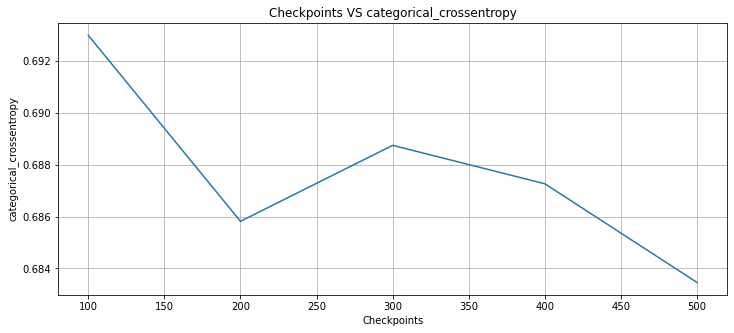

In [14]:
cat_cross = [ ckp[model.loss_fn] for ckp in checkpoints ]
draw_plot(x = [(i+1)*breakpoint for i in range(len(checkpoints))], y_list = [cat_cross], x_label = 'Checkpoints', \
    y_label = model.loss_fn)

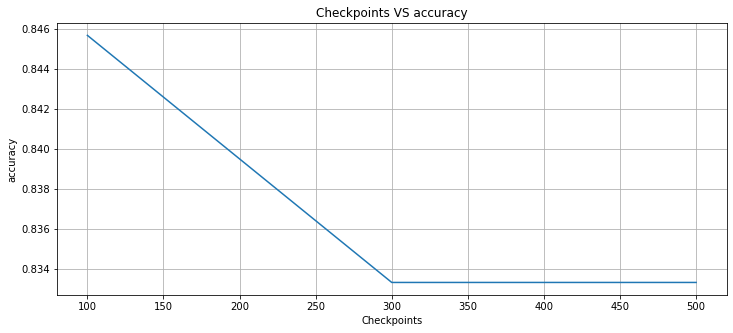

In [15]:
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [(i+1)*breakpoint for i in range(len(checkpoints))], y_list = [acc], x_label = 'Checkpoints', \
    y_label = 'accuracy')

In [16]:
print(model)

Layer 1
Neuron 0: weights:
[[1.5070522]
 [1.8935267]
 [2.3356953]
 [2.9977837]
 [2.1403923]]
 bias: [-2.557674]

Neuron 1: weights:
[[-1.602844  ]
 [ 2.4095693 ]
 [-0.47161776]
 [ 1.8830618 ]
 [-1.9050527 ]]
 bias: [0.75910884]

Neuron 2: weights:
[[-3.]
 [-3.]
 [-3.]
 [-3.]
 [-3.]]
 bias: [-0.42005154]

Neuron 3: weights:
[[ 1.2816136 ]
 [-1.8188889 ]
 [ 0.06724267]
 [ 0.92587775]
 [-1.8340435 ]]
 bias: [3.]

$
Layer 2
Neuron 0: weights:
[[-0.8472292 ]
 [-1.2518036 ]
 [ 2.5007133 ]
 [ 0.10339252]]
 bias: [1.2433006]

Neuron 1: weights:
[[-1.9081141]
 [ 2.129912 ]
 [-0.8018667]
 [-1.9734334]]
 bias: [1.2829218]

Neuron 2: weights:
[[-1.2780234]
 [ 1.5181687]
 [ 0.0932759]
 [-3.       ]]
 bias: [1.6164078]

$

